<a href="https://colab.research.google.com/github/Federico6419/MachineLearningProject/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium              #Install Gymnasium
!pip install swig                   #This solves the error in the installation of gymnasium[box2d]
!pip install gymnasium[box2d]       #Install Box2D
!pip install gym-notebook-wrapper   #This installs Gym-Notebook-Wrapper, that provides small wrappers for running and rendering OpenAI Gym

#To solve the xvfb missing file problem
!sudo apt-get install xvfb
!pip install xvfbwrapper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373073 sha256=efaf40e7f0b038ab1a146f88d5dbbe97093200bfc3c720f18f3e381cf8fcaddb
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkb

In [2]:
!git clone https://github.com/Federico6419/MachineLearningProject               #It clones my github repository
%cd MachineLearningProject

Cloning into 'MachineLearningProject'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 449 (delta 19), reused 6 (delta 6), pack-reused 409
Receiving objects: 100% (449/449), 4.67 MiB | 9.37 MiB/s, done.
Resolving deltas: 100% (268/268), done.
/content/MachineLearningProject


RANDOM POLICY
The cumulative reward is: 20.97701149425283
Episode:  0
RANDOM POLICY
The cumulative reward is: 12.037037037037125
Episode:  1
RANDOM POLICY
The cumulative reward is: 5.487804878048859
Episode:  2
RANDOM POLICY
The cumulative reward is: 14.426523297491128
Episode:  3
RANDOM POLICY
The cumulative reward is: 7.786885245901729
Episode:  4
RANDOM POLICY
The cumulative reward is: 2.7777777777777963
Episode:  5
RANDOM POLICY
The cumulative reward is: 8.707865168539414
Episode:  6
RANDOM POLICY
The cumulative reward is: -3.851963746223556
Episode:  7
RANDOM POLICY
The cumulative reward is: -2.707006369426747
Episode:  8
RANDOM POLICY
The cumulative reward is: -4.472140762463338
Episode:  9
Tests for Random policy finished after 10 episodes
Q-TABLE POLICY
The cumulative reward is: 14.007092198581386
Episode:  0
Q-TABLE POLICY
The cumulative reward is: 16.533546325878348
Episode:  1
Q-TABLE POLICY
The cumulative reward is: 7.608695652173797
Episode:  2
Q-TABLE POLICY
The cumulativ

FileNotFoundError: ignored

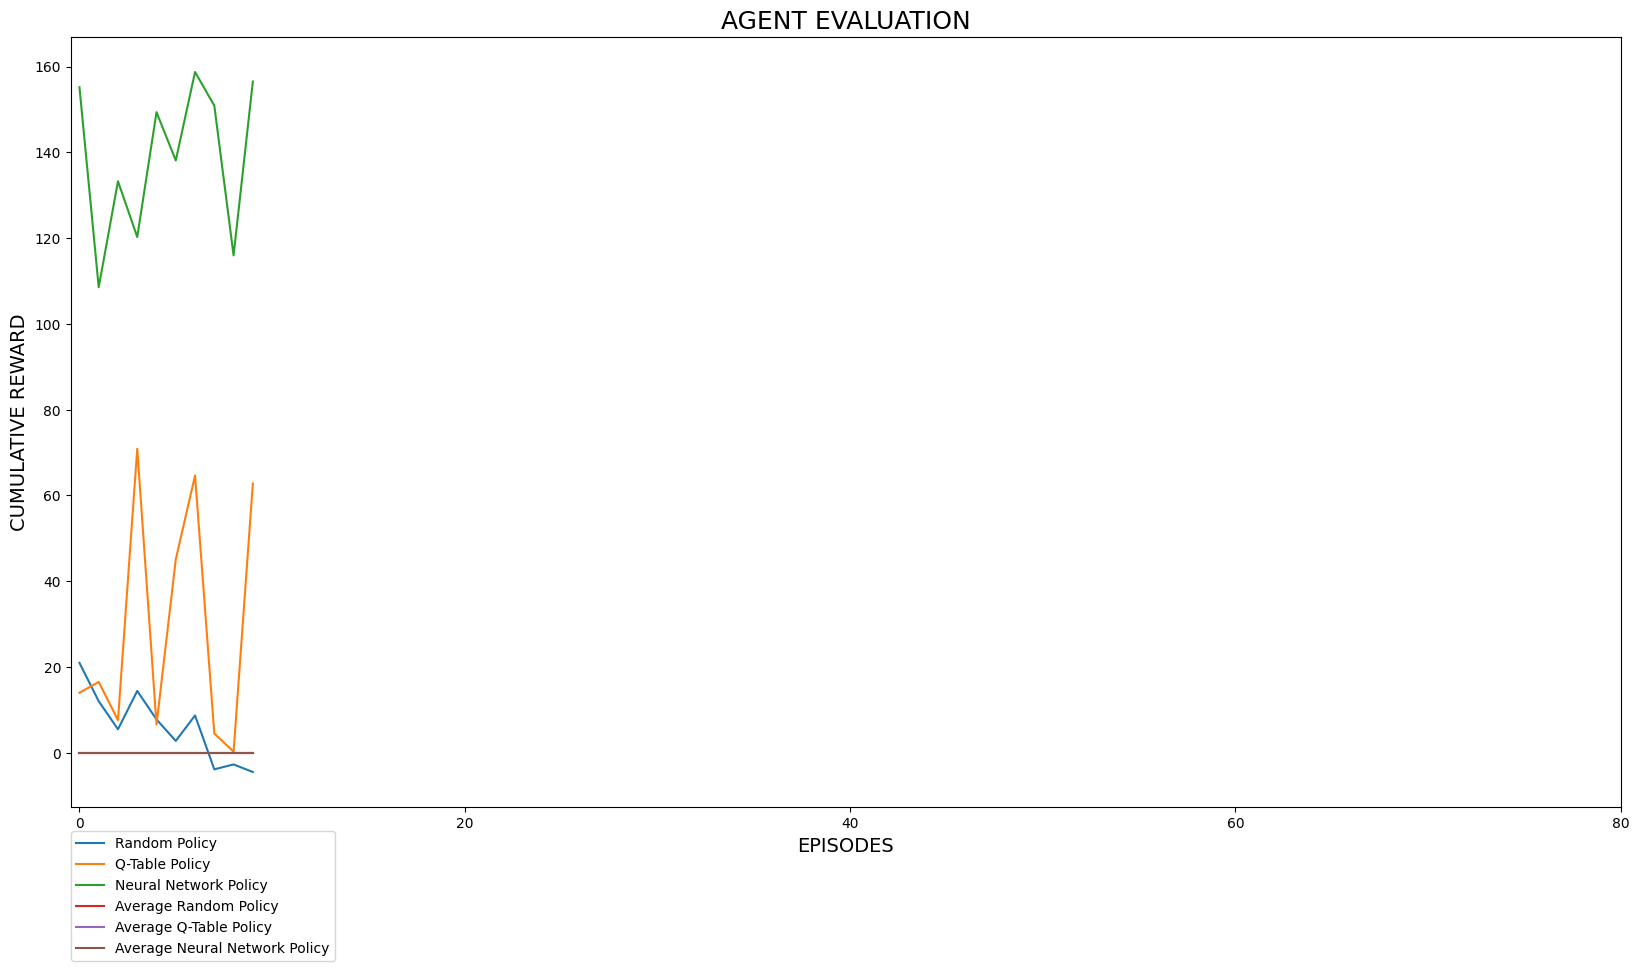

In [22]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from collections import deque
import config_test
from model import Model
import matplotlib.pyplot as plt
import cv2
import csv

#Average rewards
average_random = np.zeros(config_test.NUM_EPISODES)
average_QTable = np.zeros(config_test.NUM_EPISODES)
average_nn = np.zeros(config_test.NUM_EPISODES)

#Cumulative reward
cum_reward_random = np.zeros(config_test.NUM_EPISODES)
cum_reward_QTable = np.zeros(config_test.NUM_EPISODES)
cum_reward_nn = np.zeros(config_test.NUM_EPISODES)

#Action Space
action_space = [
                (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2),
                (-1, 1,   0), (0, 1,   0), (1, 1,   0),
                (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2),
                (-1, 0,   0), (0, 0,   0), (1, 0,   0)
              ]

#This is the function that discretizes the image
def discretize_image(image):
    image = image.unsqueeze(0)

    #Execute the 3x3 Average Pooling
    pooling = nn.AvgPool2d(8, stride=8)
    image = pooling(image)
    image = image.squeeze(0)

    #Create the image identifier
    string = "S"
    for i, x in enumerate(image.numpy()):
        for j in x:
            if(j < 30):
                string = string + "0"
            elif(j < 60):
                string = string + "1"
            elif(j < 90):
                string = string + "2"
            elif(j < 120):
                string = string + "3"
            elif(j < 150):
                string = string + "4"
            elif(j < 180):
                string = string + "5"
            elif(j < 210):
                string = string + "6"
            elif(j < 256):
                string = string + "7"

    return string


#Initialize the Model and load weights
model = Model().to(config_test.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config_test.LR)
config_test.load_model(config_test.CHECKPOINT_FOLDER, model, optimizer)

#Load the Q-Table csv file
Q_Table = {}
with open('QTable/QTable.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    headers = next(csvreader)  # Leggi la prima riga come intestazione/chiavi
    for header in headers:
        Q_Table[header] = []  # Inizializza le liste vuote per ogni colonna

    for row in csvreader:
        for col_idx, value in enumerate(row):
            Q_Table[headers[col_idx]].append(value)


#Policies
def policy(p, state):
    if(p == "Random"):
        return action_space[random.randrange(len(action_space))]          #Sample a random action from the Action Space

    elif(p == "Q-Table"):
        if state in Q_Table:
            return action_space[np.argmax(Q_Table[state])]                #Return the action with the highest value for the current state in the Q-Table
        else:
            return (0, 1, 0)

    elif(p == "nn"):
        prediction = model(torch.from_numpy(state.astype('float32')).to(config_test.DEVICE)).detach().cpu().numpy()
        action = action_space[np.argmax(prediction)]              #Select the action with the maximum predicted Q-Value
        return action


#Initialize the Car Racing Environment
env = gym.make("CarRacing-v2", render_mode="human")
observation = env.reset()

#Testing
def test(strategy):
    c_reward = 0                #Cumulative reward
    total_reward = 0
    episode = 0
    for i in range(config_test.NUM_EPISODES):
            observation = env.reset()

            observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)           #Convert the state into a Grayscale Image, that is a Matrix 96x96 composed by Integer values

            if(strategy == "Neural Network policy"):
                frames_queue = deque([observation]*3, maxlen = 3)
            elif(strategy == "Q-Table policy"):
                #Discretize the image
                #observation = torch.from_numpy(observation.astype('float32'))
                #observation = discretize_image(observation)
                print("Q-TABLE POLICY")
            else:
                print("RANDOM POLICY")

            for _ in range(250):
                env.render()

                if(strategy == "Random policy"):
                    action = policy("Random", observation)
                elif(strategy == "Q-Table policy"):
                    observation = torch.from_numpy(observation.astype('float32'))
                    observation = discretize_image(observation)
                    action = policy("Q-Table", observation)
                elif(strategy == "Neural Network policy"):
                    current_frame = np.array(frames_queue)
                    action = policy("nn", current_frame)

                observation, reward, done, truncated = env.step(action)
                c_reward += reward

                observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)

                if(strategy == "Neural Network policy"):
                    frames_queue.append(observation)

                if done or truncated:
                    total_reward += c_reward
                    break

            if(strategy == "Random policy"):
                cum_reward_random[episode] = c_reward # save the cum_reward for the relative episode
                average_random[episode]=total_reward/(episode+1)
            elif(strategy == "Q-Table policy"):
                cum_reward_QTable[episode] = c_reward
                average_QTable[episode]=total_reward/(episode+1)
            elif(strategy == "Neural Network policy"):
                cum_reward_nn[episode] = c_reward
                average_nn[episode]=total_reward/(episode+1)

            print("The cumulative reward is:",c_reward)
            c_reward = 0 # reset the current cumulative reward
            print("Episode: ",episode)
            episode += +1

    print(f"Tests for {strategy} finished after {config_test.NUM_EPISODES} episodes")



test("Random policy")
test("Q-Table policy")
test("Neural Network policy")

env.close()


###### after saved results of the test plot it
#first create an array with natural number to represent the episodes
ep = np.zeros(config_test.NUM_EPISODES,int)
for i in range (config_test.NUM_EPISODES):
    ep[i] = i

fig = plt.figure(figsize=(20, 10))
#fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax = fig.add_subplot(111)
ax.plot(ep, cum_reward_random, label="Random Policy")  # Plot some data on the axes.
ax.plot(ep, cum_reward_QTable, label="Q-Table Policy")  # Plot some data on the axes.
ax.plot(ep, cum_reward_nn, label="Neural Network Policy")  # Plot some data on the axes.
ax.plot(ep, average_random, label="Average Random Policy")  # Plot some data on the axes.
ax.plot(ep, average_QTable, label="Average Q-Table Policy")  # Plot some data on the axes.
ax.plot(ep, average_nn, label="Average Neural Network Policy")  # Plot some data on the axes.
ax.set_xlabel('EPISODES', fontsize=14)  # Add an x-label to the axes.
ax.set_ylabel('CUMULATIVE REWARD', fontsize=14)  # Add a y-label to the axes.
ax.set_title("AGENT EVALUATION", fontsize=18)  # Add a title to the axes.
ax.legend(loc=(0.0, -0.2))  # Add a legend.

#specify axis tick step sizes
plt.xticks(np.arange(0,100,20))# np.arange(min,max, step)

#-----save image of the plot--------#
plt.savefig('Plot.png')